In [190]:
# generate data
import Distributions
using Revise
using ForneyLab
using Random
import ProgressMeter
using Plots

Random.seed!(42)

n_samples = 10

dimensionality = 2
rθ = [-0.9, 0.5]
ms = [[0.9, 0.1], [0.2, 0.8]]
σ(w, x) = 1/(1+exp(-w'x))

A_data = [0.9 0.1; 0.1 0.9] # Transition probabilities (some transitions are impossible)

s_0_data = [1.0, 0.0] # Initial state

# Generate some data
s_data = Vector{Vector{Float64}}(undef, n_samples) # one-hot encoding of the states
s_t_min_data = s_0_data
for t in 1:n_samples
    a = A_data*s_t_min_data
    s_data[t] = sample(ProbabilityDistribution(Categorical, p=a./sum(a))) # Simulate state transition
    
    s_t_min_data = s_data[t]
end
πs = [σ(rθ, ms[findmax(s_data[1])[2]]) for i in 1:n_samples]
outputs = [rand(Distributions.Bernoulli(πs[i])) for i in 1:n_samples];
;

In [324]:
# test nonlinear

using LinearAlgebra
import ForneyLab: unsafeMean, unsafeCov

graph = FactorGraph()

T = n_samples
x = Vector{Variable}(undef, T)
z = Vector{Variable}(undef, T)
s = Vector{Variable}(undef, T) # one-hot coding
y = Vector{Variable}(undef, T)

@RV A ~ Dirichlet([0.5 0.5; 0.5 0.5])
@RV s_0 ~ Categorical(1/dimensionality*ones(dimensionality))

@RV m_1 ~ GaussianMeanPrecision([0.9, 0.1], 1e-4*Matrix(Diagonal(ones(dimensionality))))
@RV w_1 ~ Wishart(1e-4*Matrix(Diagonal(ones(dimensionality))), dimensionality)
@RV m_2 ~ GaussianMeanPrecision([0.2, 0.8], 1e-4*Matrix(Diagonal(ones(dimensionality))))
@RV w_2 ~ Wishart(1e-4*Matrix(Diagonal(ones(dimensionality))), dimensionality)

@RV θ  ~ GaussianMeanPrecision(placeholder(:m_θ, dims=(dimensionality,)), placeholder(:W_θ, dims=(dimensionality, dimensionality)))
f(w, x) = 1/(1+exp(-w'x))
s_t_min = s_0
for i in 1:T
    @RV s[i] ~ Transition(s_t_min, A)
    @RV z[i] ~ GaussianMixture(s[i], m_1, w_1, m_2, w_2)
    @RV x[i] ~ Nonlinear{Sampling}(θ, z[i], g=f, in_variates=[Multivariate, Multivariate], out_variate=Univariate)
    @RV y[i] ~ Bernoulli(x[i])
    
    s_t_min = s[i]
    placeholder(y[i], :y, index=i)
end

In [325]:
draw();

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.47.2 (20210527.0053)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 4279982954947225053 -->
 
 4279982954947225053 
 
 placeholder_y_8 
 
<!-- 17441708025511585740 -->
 
 17441708025511585740 
 
 Ber 
 bernoulli_8 
 
<!-- 4279982954947225053--17441708025511585740 -->
 
 4279982954947225053--17441708025511585740 
 
 y_8 
 1 out 
 1 out 
 
<!-- 16530621410064223614 -->
 
 16530621410064223614 
 
 = 
 equ_m_2_9 
 
<!-- 17886996435237984790 -->
 
 17886996435237984790 
 
 = 
 equ_m_2_8 
 
<!-- 16530621410064223614--17886996435237984790 -->
 
 16530621410064223614--17886996435237984790 
 
 m_2 
 3 3 
 2 2 
 
<!-- 12243353461568622335 -->
 
 12243353461568622335 
 
 GM 
 gaussianmixture_10 
 
<!-- 16530621410064223614--12243353461568622335 -->
 
 16530621410064223614--12243353461568622335 
 
 m_2 
 5 m2 
 3 3 
 
<!-- 3031394205092432395 -->
 
 3031394205092432395 
 
 GM 
 gaussianmixture_9 
 
<!-- 16530621410064223614--3031394205092432395 -->
 
 16530621410064223614--3031394205092432395 
 
 m_2 
 5 m2 
 1 1 
 
<!-- 5268004883007911218 -->
 
 5268004883007911218 
 
 GM 
 gaussianmixture_8 
 
<!-- 14128258016302865904 -->
 
 14128258016302865904 
 
 = 
 equ_m_2_2 
 
<!-- 18188129234741814365 -->
 
 18188129234741814365 
 
 GM 
 gaussianmixture_2 
 
<!-- 14128258016302865904--18188129234741814365 -->
 
 14128258016302865904--18188129234741814365 
 
 m_2 
 5 m2 
 1 1 
 
<!-- 5288937705368505631 -->
 
 5288937705368505631 
 
 = 
 equ_m_2_1 
 
<!-- 14128258016302865904--5288937705368505631 -->
 
 14128258016302865904--5288937705368505631 
 
 m_2 
 3 3 
 2 2 
 
<!-- 6335103723067873475 -->
 
 6335103723067873475 
 
 clamp_1 
 
<!-- 1648641679715120576 -->
 
 1648641679715120576 
 
 placeholder_y_7 
 
<!-- 10539596572189320845 -->
 
 10539596572189320845 
 
 Ber 
 bernoulli_7 
 
<!-- 1648641679715120576--10539596572189320845 -->
 
 1648641679715120576--10539596572189320845 
 
 y_7 
 1 out 
 1 out 
 
<!-- 6630941473607762481 -->
 
 6630941473607762481 
 
 = 
 equ_A_5 
 
<!-- 14152092295224993153 -->
 
 14152092295224993153 
 
 T 
 transition_5 
 
<!-- 6630941473607762481--14152092295224993153 -->
 
 6630941473607762481--14152092295224993153 
 
 A 
 3 a 
 1 1 
 
<!-- 15285769883709926658 -->
 
 15285769883709926658 
 
 = 
 equ_A_4 
 
<!-- 6630941473607762481--15285769883709926658 -->
 
 6630941473607762481--15285769883709926658 
 
 A 
 3 3 
 2 2 
 
<!-- 4483820485201950938 -->
 
 4483820485201950938 
 
 = 
 equ_m_2_4 
 
<!-- 14613024519891741822 -->
 
 14613024519891741822 
 
 GM 
 gaussianmixture_4 
 
<!-- 4483820485201950938--14613024519891741822 -->
 
 4483820485201950938--14613024519891741822 
 
 m_2 
 5 m2 
 1 1 
 
<!-- 2534771570979331736 -->
 
 2534771570979331736 
 
 = 
 equ_m_2_3 
 
<!-- 4483820485201950938--2534771570979331736 -->
 
 4483820485201950938--2534771570979331736 
 
 m_2 
 3 3 
 2 2 
 
<!-- 15865314762131457092 -->
 
 15865314762131457092 
 
 Cat 
 categorical_1 
 
<!-- 3221762798686927849 -->
 
 3221762798686927849 
 
 clamp_2 
 
<!-- 15865314762131457092--3221762798686927849 -->
 
 15865314762131457092--3221762798686927849 
 
 clamp_2 
 1 out 
 2 p 
 
<!-- 17826869434197358999 -->
 
 17826869434197358999 
 
 clamp_7 
 
<!-- 9706894518683486875 -->
 
 9706894518683486875 
 
 T 
 transition_1 
 
<!-- 9706894518683486875--15865314762131457092 -->
 
 9706894518683486875--15865314762131457092 
 
 s_0 
 1 out 
 2 in1 
 
<!-- 15909094216327593041 -->
 
 15909094216327593041 
 
 = 
 equ_w_1_1 
 
<!-- 12945332041417966740 -->
 
 12945332041417966740 
 
 GM 
 gaussianmixture_1 
 
<!-- 15909094216327593041--12945332041417966740 -->
 
 15909094216327593041--12945332041417966740 
 
 w_1 
 4 w1 
 2 2 
 
<!-- 6820388145380556658 -->
 
 6820388145380556658 
 
 W 
 wishart_1 
 
<!-- 15909094216327593041--6820388145380556658 -->
 
 15909094216327593

In [326]:
vague(Wishart, 2)

W(v=diag[1.00e+12, 1.00e+12], nu=2.00)


In [327]:
# Define posterior factorization
pfz = PosteriorFactorization(A, [s_0; s], m_1, w_1, m_2, w_2, z, ids=[:A, :S, :M1, :W1, :M2, :W2, :Z]);

In [328]:
# Compile algorithm
algo = messagePassingAlgorithm(free_energy=true)

# Generate source code
src_code = algorithmSourceCode(algo, free_energy=true);

In [329]:
# println(src_code)

In [330]:
# Load algorithm
eval(Meta.parse(src_code))

freeEnergy (generic function with 1 method)

In [331]:
n_messages = length(initZ());

function initZ(n_messages)
    messages = Array{Message}(undef, n_messages)
    for i in 1:length(messages)
        messages[i] = Message(vague(GaussianMeanPrecision, 2))
    end
    messages
end

initZ (generic function with 2 methods)

In [332]:
messages = initZ(n_messages);

Cat(p=[0.20, 0.80])


In [378]:
# Initial posterior factors
marginals = Dict{Symbol, ProbabilityDistribution}(:A => ProbabilityDistribution(MatrixVariate, Dirichlet, a=[0.5 0.5; 0.5 0.5]), 
                                                  :m_1 => ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=[0.9, 0.1], w=Matrix(Diagonal(ones(2)))),
                                                  :w_1 => ProbabilityDistribution(MatrixVariate, Wishart, v=Matrix(Diagonal(ones(dimensionality))), nu=2.00),
                                                  :m_2 => ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=[0.2, 0.8], w=Matrix(Diagonal(ones(2)))),
                                                  :w_2 => ProbabilityDistribution(MatrixVariate, Wishart, v=Matrix(Diagonal(ones(dimensionality))), nu=2.00))

for i in 0:n_samples
    marginals[:s_*i] = ProbabilityDistribution(Univariate, Categorical, p=[0.2, 0.8])
end

# Initialize data
data = Dict(:y => outputs, :m_θ => [-0.9, 0.5], :W_θ => Matrix(Diagonal(ones(dimensionality))))
n_its = 50

# Run algorithm
F = Vector{Float64}(undef, n_its)
ProgressMeter.@showprogress for i in 1:n_its
    stepZ!(data, marginals, messages)
    stepS!(data, marginals)
#     stepA!(data, marginals)
    stepM1!(data, marginals)
#     stepW1!(data, marginals)
    stepM2!(data, marginals)
#     stepW2!(data, marginals) 
    F[i] = freeEnergy(data, marginals)
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


In [379]:
unsafeMean(marginals[:θ])

2-element Vector{Float64}:
 -1.6672489362525134
  0.7263363142402965

In [380]:
veθ = unsafeCov(marginals[:θ])

2×2 Matrix{Float64}:
  0.539258  -0.20911
 -0.20911    1.23986

In [381]:
es = [unsafeMean(marginals[:s_*i]) for i in 1:n_samples]

10-element Vector{Vector{Float64}}:
 [0.5000007692656606, 0.4999992307343394]
 [0.49999698633848216, 0.5000030136615179]
 [0.5000007692656606, 0.4999992307343394]
 [0.5000007692656606, 0.4999992307343394]
 [0.5000007692656606, 0.4999992307343394]
 [0.5000007692656606, 0.4999992307343394]
 [0.5000007692656606, 0.4999992307343394]
 [0.5000007692656606, 0.4999992307343394]
 [0.49999698633848216, 0.5000030136615179]
 [0.5000007691771129, 0.4999992308228871]

In [382]:
ez = [unsafeMean(marginals[:z_*i]) for i in 1:n_samples]

10-element Vector{Vector{Float64}}:
 [1.1400511684534855, 0.3542493382446615]
 [0.4972567549362774, 0.6242157520108155]
 [1.1400511684534855, 0.3542493382446614]
 [1.1400511684534855, 0.3542493382446614]
 [1.1400511684534853, 0.3542493382446614]
 [1.1400511684534853, 0.3542493382446614]
 [1.1400511684534855, 0.3542493382446615]
 [1.1400511684534855, 0.3542493382446614]
 [0.4972567549362774, 0.6242157520108155]
 [1.1400461578737315, 0.3542668786578484]

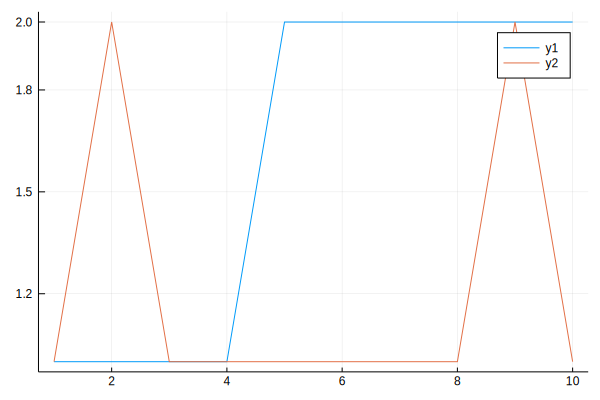

In [383]:
plot(map(x -> x[2], findmax.(s_data)))
plot!(map(x -> x[2], findmax.(es)))